# Convolutional Neural Network (CNN) / Classify Multi-label Emotions

In [1]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/installation.html
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 382.6 MB 35 kB/s 


In [2]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 418 kB 754 kB/s 
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.19.0-cp37-cp37m-linux_x86_64.whl size=120499 sha256=0f5977733bc65408e99452259c55acd351c38ef554891ceb5a69cf35a6902703
  Stored in directory: /root/.cache/pip/wheels/7f/8c/08/7adf9f8b758908640a1a1569489d8ab08a81a05192aa508363
Successfully built nvidia-dali-tf-plugin-cuda110


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [4]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Record cell run time.
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.0 MB/s 
time: 397 µs (started: 2022-11-22 08:31:19 +00:00)


In [7]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.51 ms (started: 2022-11-22 08:31:19 +00:00)


### Load label data.

In [8]:
# Load labels, check headers, check data shape.
f_PATH = "/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/"
df_label = pd.read_csv(f_PATH +'label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv(f_PATH +'label/label_multi-label_valid.csv')
label_train = pd.read_csv(f_PATH +'label/label_multi-label_train.csv')
label_test = pd.read_csv(f_PATH +'label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 3.04 s (started: 2022-11-22 08:31:19 +00:00)


## 사양

In [9]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.162
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale

In [10]:
!nvidia-smi

Tue Nov 22 08:31:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Define training pipeline.

In [11]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_train.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 122 ms (started: 2022-11-22 08:31:23 +00:00)


## Define validation pipeline.

In [12]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_valid.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 3.5 ms (started: 2022-11-22 08:31:23 +00:00)


## Train CNN model for classifying multi-label emotions.

In [13]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)   
    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)

        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)  
      
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)        
        
        number_of_classes = 24
        
        inputs = keras.Input(shape=(64, 64, 3))
        conv1 = keras.layers.Conv2D(128,(5, 5), padding='same', activation='relu')(inputs)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(conv1)         
        conv2 = keras.layers.Conv2D(64,(5, 5), padding='same', activation='relu')(do1)
        do2 = keras.layers.Dropout(0.5, seed=set_seed)(conv2)         
        conv3 = keras.layers.Conv2D(32,(5, 5), padding='same', activation='relu')(do2)
        do3 = keras.layers.Dropout(0.5, seed=set_seed)(conv3)       
        flatten = keras.layers.Flatten()(do3)   
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(flatten) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)          
       
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          )#callbacks=[es_callback])      

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        204864    
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        51232     
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)        0     

In [14]:
from keras.models import load_model
clf.save('/content/drive/MyDrive/facial_emotion_recognition_using_K-drama_dataset-main/model/cnn_multi.h5')

time: 703 ms (started: 2022-11-22 19:54:24 +00:00)


In [15]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 811 µs (started: 2022-11-22 19:54:25 +00:00)


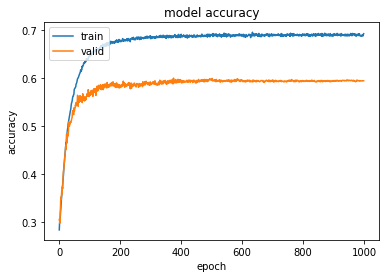

time: 345 ms (started: 2022-11-22 19:54:25 +00:00)


In [16]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

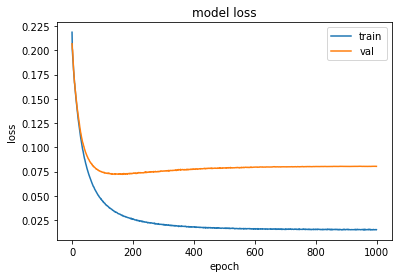

time: 141 ms (started: 2022-11-22 19:54:25 +00:00)


In [17]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Define test pipeline.

In [18]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = [f_PATH+'tfrecords/multi-label_test.tfrecords'],
             index_path = [f_PATH+'tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 2.76 ms (started: 2022-11-22 19:54:25 +00:00)


### Check test data accuracy.

In [19]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
    #with strategy.scope():        
        # Create dataset
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset element_spec=(TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 24), dtype=tf.int64, name=None))>
3882/3882 [==============================] - 17s 4ms/step - loss: 0.0747 - accuracy: 0.6239
Test accuracy: 0.6239051818847656
5/5 [==============================] - 0s 3ms/step
A test output from the last layer: [1.8206009e-23 1.1434804e-12 0.0000000e+00 1.5034727e-03 4.1592166e-06
 4.7874673e-12 1.5411458e-10 1.7034326e-09 5.1881849e-10 2.5116883e-16
 2.2566619e-26 6.3855941e-03 9.9632168e-01 4.6109128e-10 3.1032354e-32
 1.5934227e-03 5.6171869e-13 1.2215965e-12 1.0255257e-08 2.2486749e-22
 1.1751106e-14 2.6541712e-28 6.3230834e-09 1.3039626e-11]
Index of the maximum value: 12
Label: upset
time: 16.9 s (started: 2022-11-22 19:54:25 +00:00)


In [20]:
predictions

array([[1.8206009e-23, 1.1434804e-12, 0.0000000e+00, 1.5034727e-03,
        4.1592166e-06, 4.7874673e-12, 1.5411458e-10, 1.7034326e-09,
        5.1881849e-10, 2.5116883e-16, 2.2566619e-26, 6.3855941e-03,
        9.9632168e-01, 4.6109128e-10, 3.1032354e-32, 1.5934227e-03,
        5.6171869e-13, 1.2215965e-12, 1.0255257e-08, 2.2486749e-22,
        1.1751106e-14, 2.6541712e-28, 6.3230834e-09, 1.3039626e-11],
       [3.8129406e-17, 1.7587943e-05, 9.0170829e-35, 1.1458871e-11,
        2.5714762e-04, 9.4868141e-01, 3.5472986e-10, 3.2503982e-07,
        3.2272141e-02, 7.4425202e-23, 6.9918161e-15, 5.8196068e-01,
        1.1129677e-04, 2.0348616e-12, 0.0000000e+00, 2.5168969e-08,
        9.4347676e-08, 1.3415460e-16, 1.8033081e-05, 5.8351559e-22,
        1.7427833e-10, 5.8645174e-24, 2.6202563e-04, 1.9232327e-14],
       [1.0086549e-22, 1.8901400e-21, 0.0000000e+00, 5.0223883e-07,
        5.9189696e-02, 2.5038480e-06, 4.9044492e-12, 1.6415046e-05,
        6.6710098e-05, 1.9754905e-30, 3.691191

time: 7.57 ms (started: 2022-11-22 19:54:42 +00:00)


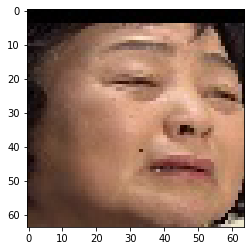

time: 155 ms (started: 2022-11-22 19:54:42 +00:00)


In [21]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [22]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 5.49 ms (started: 2022-11-22 19:54:42 +00:00)


# Result

## Result : Argmax Accuracy & Micro F1-score

In [23]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

3882/3882 [==============================] - 9s 2ms/step
time: 10.2 s (started: 2022-11-22 19:54:42 +00:00)


In [24]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 2.17 s (started: 2022-11-22 19:54:52 +00:00)


In [25]:
true_test.shape

(3882, 24)

time: 7.07 ms (started: 2022-11-22 19:54:55 +00:00)


In [26]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.6267387944358578
f1_micro: 0.6267387944358578
time: 703 ms (started: 2022-11-22 19:54:55 +00:00)


### Result: Threshold=0.5 Accuracy & Micro F1-score

In [27]:
pred_05 = pred_test.copy()
pred_05

array([[1.8206009e-23, 1.1434804e-12, 0.0000000e+00, ..., 2.6541712e-28,
        6.3230834e-09, 1.3039626e-11],
       [3.8129406e-17, 1.7587943e-05, 9.0170829e-35, ..., 5.8645174e-24,
        2.6202563e-04, 1.9232327e-14],
       [1.0086549e-22, 1.8901400e-21, 0.0000000e+00, ..., 1.5730248e-20,
        2.1379699e-12, 2.9275840e-10],
       ...,
       [1.3212826e-22, 3.3107627e-21, 0.0000000e+00, ..., 1.6289203e-14,
        6.2107497e-13, 1.3872379e-18],
       [1.9522978e-10, 9.9999785e-01, 1.5335747e-29, ..., 4.2361987e-19,
        6.4320687e-07, 2.3728428e-10],
       [2.7043062e-13, 4.8788891e-14, 4.0264255e-31, ..., 2.2371207e-14,
        2.4946644e-06, 6.0948706e-26]], dtype=float32)

time: 7.94 ms (started: 2022-11-22 19:54:55 +00:00)


In [28]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.59 s (started: 2022-11-22 19:54:55 +00:00)


In [29]:
accuracy_score(true_test, pred_05)

0.7323544564657393

time: 24 ms (started: 2022-11-22 19:54:57 +00:00)


In [30]:
f1_score(true_test, pred_05, average='micro')

0.8599162881823849

time: 37.5 ms (started: 2022-11-22 19:54:57 +00:00)


### Result: Threshold=0.4 Accuracy & Micro F1-score

In [31]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 2.01 s (started: 2022-11-22 19:54:57 +00:00)


In [32]:
accuracy_score(true_test, pred_04)

0.7323544564657393

time: 19.9 ms (started: 2022-11-22 19:54:59 +00:00)


In [33]:
f1_score(true_test, pred_04, average='micro')

0.8598637078455356

time: 27.8 ms (started: 2022-11-22 19:54:59 +00:00)


### Result: Threshold=0.3 Accuracy & Micro F1-score

In [34]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.68 s (started: 2022-11-22 19:54:59 +00:00)


In [35]:
accuracy_score(true_test, pred_03)

0.726172076249356

time: 18.8 ms (started: 2022-11-22 19:55:01 +00:00)


In [36]:
f1_score(true_test, pred_03, average='micro')

0.8568255595421153

time: 21.1 ms (started: 2022-11-22 19:55:01 +00:00)


### Result: Threshold=0.2 Accuracy & Micro F1-score

In [37]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.37 s (started: 2022-11-22 19:55:01 +00:00)


In [38]:
accuracy_score(true_test, pred_02)

0.7042761463163318

time: 10.2 ms (started: 2022-11-22 19:55:02 +00:00)


In [39]:
f1_score(true_test, pred_02, average='micro')

0.8486710963455149

time: 16.8 ms (started: 2022-11-22 19:55:02 +00:00)


### Result: Threshold=0.1 Accuracy & Micro F1-score

In [40]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.42 s (started: 2022-11-22 19:55:02 +00:00)


In [41]:
accuracy_score(true_test, pred_01)

0.6530139103554868

time: 10.4 ms (started: 2022-11-22 19:55:04 +00:00)


In [42]:
f1_score(true_test, pred_01, average='micro')

0.8302872062663185

time: 17.5 ms (started: 2022-11-22 19:55:04 +00:00)


time: 26.4 ms (started: 2022-11-22 19:55:04 +00:00)
